<span style="color:#A00;font-weight:bold">Missing data: this notebook relies on calibration FITS files from Nickel. The files are not provided.</span>

## Computational routines for statistics

*Poisson and Gaussian probability distributions, Stirling approximation, Monte-Carlo approach for uncertainty propagation*

In [1]:
# As always, we need NumPy, MatPlotLib and Astropy FITS
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

In this entire notebook, I will be working with a single randomly chosen flat field corrected by a single randomly chosen bias frame. You can (and should) experiment with other data too. First, load the two images and subtract the bias:

In [2]:
data_file = '../../FITS/data-2019-01-11/d118.fits'       # Point this to a flat on YOUR hard drive
bias_file = '../../FITS/data-2019-01-11/d100.fits'       # Point this to a bias on YOUR hard drive


h = fits.open(data_file)
if h[0].header['OBJECT'] not in ['flat', 'flats']:    # The "not in" statement checks if the value exists
                                                      # in a list

    # \n means "line break". Below, a formatted output is attempted. Take a closer look at this line and
    # try to understand what is going on. Test it by loading in a bias frame instead of a flat.
    print "THIS IS NOT A FLAT FIELD! \n This is a {frame_type} frame".format(frame_type = h[0].header['OBJECT'])
    
# Load the data and typecast it into float
data = h[0].data * 1.0

h.close()    # Do not forget!


# Print some basic information about the file
data_shape = np.shape(data)
print "Exposure time: {exp}".format(exp = h[0].header['EXPTIME'])
print "The shape of data is {width}x{height} pixels".format(width = data_shape[1], height = data_shape[0])


# Now, do the same for the bias frame (should probably define a function for this!)
h = fits.open(bias_file)
if h[0].header['OBJECT'] != 'bias':
    print "THIS IS NOT A BIAS FRAME! \n This is a {frame_type} frame".format(frame_type = h[0].header['OBJECT'])
bias = h[0].data * 1.0
h.close()


# Correct the flat for bias
data = data - bias

Exposure time: 48
The shape of data is 1056x1024 pixels


## A short aside regarding conditional array slicing

In [3]:
# Remember that NumPy arrays support automatic iteration (native Python lists do not).
# This applies to both arithmetic and logical expressions. For example:
my_array = np.array([0, 1, 2, 3, 4])
print my_array < 3       # Prints    [ True  True  True False False]

# The result of such expression is an array of True/False values. This array can
# be used to slice other arrays of the same dimension, where the slice will only
# contain those elements that correspond to True:
print my_array[my_array < 3]             # Prints [0 1 2]
got_characters = np.array(['Eddard Stark', 'Daenerys Targaryen', 'Jon Snow', 'Sansa Stark', 'Theon Greyjoy'])
print got_characters[my_array < 3]       # Prints ['Eddard Stark' 'Daenerys Targaryen' 'Jon Snow']

# A caveat concerns "not", "or" and "and" operators. The following will produce an error:
print my_array[(my_array < 3) and (my_array > 0)]    # Error! Comment this out to proceed!

# Instead, we need to use np.logical_or(), np.logical_and() and np.logical_not() functions:
print my_array[np.logical_and(my_array < 3, my_array > 0)]    # Prints [1 2]

# Most of those have shorthands. Use "~" for "not", "&" for "and" and "|" for "or". E.g.:
print my_array[(my_array < 3) & (my_array > 0)]        # Prints [1 2], again
print my_array[(my_array > 3) | (my_array < 1)]        # Prints [0 4]

[ True  True  True False False]
[0 1 2]
['Eddard Stark' 'Daenerys Targaryen' 'Jon Snow']


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Probability histograms

The learning objective of this computing session is your ability to overplot FITS histograms with Poisson and Gaussian probability distributions. The Poisson distribution models **independent** events occurring at a **constant** mean rate in time or space. The arrival of photons at a CCD, emitted by a source of constant brightness, is a likely candidate for Poisson statistics.

To compare our data against a theoretical probability distribution, we need to plot its histogram first. Below, I will borrow the `my_hist()` function from the previous computing session (FITS Basics) and improve it in two ways:

* The $y$-axis must show probabilities instead of frequencies, as it would in a regular histogram. Frequencies are, of course, directly proportional to probabilities (an event that is twice as likely to occur will occur twice as often), which means that the conversion from frequencies to probabilities is a matter of scale. The fact that all probabilities must add to $1$ can be used to estimate the necessary scaling factor.
* To suppress the outliers, I will cap the data at $3\sigma$ below and above the mean value. The probability of a genuine data point lying outside $3\sigma$ is approximately $0.3 \%$, meaning that a predominating majority of these points are not genuine and are outliers.

Text(0,0.5,'Probability')

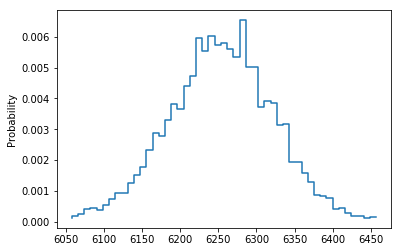

In [4]:
def remove_outliers(data, sigmas):
    """Remove all data points that are too far from the mean"""
    mean = np.mean(data)     # Use YOUR mean function here
    std = np.std(data)       # Use YOUR std function here
    
    # Condition to identify outliers
    condition = np.logical_or(data < mean - sigmas * std, data > mean + sigmas * std)
    
    while (len(data[condition]) > 0):              # While there are items satisfying the condition...
        data = data[np.logical_not(condition)]     # ...remove them!
        mean = np.mean(data); std = np.std(data)   # Recalculate mean and std. ";" allows multiple
                                                   # commands in the same line!
        # Recalculate the condition
        condition = np.logical_or(data < mean - sigmas * std, data > mean + sigmas * std)
    return data

def my_hist(data, bins):
    """Plot a normalized histogram of 1D data with a given number of bins"""
    
    ### New addition begins here ###
    data = remove_outliers(data, 3)                # Kill all 3-sigma outliers
    ### New addition ends here ###
    
    bin_left_edges  = np.linspace(min(data), max(data), bins + 1)
    bin_left_edges = bin_left_edges[:-1]
    bin_width  = bin_left_edges[1] - bin_left_edges[0]
    bin_right_edges = bin_left_edges + bin_width
    bin_centres = (bin_left_edges + bin_right_edges) / 2.0
    bin_values = np.zeros(bins)
    for i, bin_centre in enumerate(bin_centres):
        condition = np.logical_and(data > bin_left_edges[i], data <= bin_right_edges[i])
        bin_values[i] = len(data[condition])
    
    ### New addition begin here ###
    total_area = np.sum(bin_values * bin_width)    # Find the area of the histogram
    bin_values /= total_area                       # Divide it out to ensure the area of 1
    ### New addition end here ###
    
    plt.step(bin_centres, bin_values)   # Just like plt.plot(), but the plot looks like a staircase

flattened = data[400:500,400:500].flatten()       # As before, we only plot a small slice to avoid any bias due
                                                  # to overall brightness variation
my_hist(flattened, 50)
plt.ylabel("Probability")

## Stirling approximation

Below is the standard expression for the Poisson probability distribution:

$$P(x, \mu) = e^{-\mu} \frac{\mu^x}{x!}$$

This equation can be easily evaluated for small $x$ and $\mu$, but it becomes unmanageable at large values, since both the factorial and the exponential blow up into ridiculously large numbers. In fact, Python cannot handle even 4-digit exponentials out of the box:

In [5]:
print np.e ** (1000)      # ERROR!   

OverflowError: (34, 'Result too large')

To address this issue, we will first take a logarithm of both sides to kill off any exponentials:

$$\ln(P(x, \mu)) = x\ln(\mu) - \ln(x!) - \mu$$

It turns out that $\ln(x!)$ has a very simple approximation:

$$\ln(x!) \approx \ln(\sqrt{2 \pi}) + (x+0.5)\ln(x) - x$$

This approximation is known as *Stirling approximation* after James Stirling - a British mathematician who was designing approximations for computationally demanding operations over 200 years before the first computer was invented!

The Stirling approximation is asymptotic, meaning that it gets better as $x$ grows large. The cell below implements the Stirling-approximated Poisson distribution in Python:

In [6]:
def poisson(x, mean):
    """Compute the Poisson probability of observing x given a mean value"""
    log_factorial = np.log(np.sqrt(2 * np.pi)) + (x + 0.5) * np.log(x) - x
    log_poisson = x * np.log(mean) - log_factorial - mean
    return np.e ** log_poisson

print "For x=8 and mean=7"
print "Exact probability:", np.e ** (-7.0) * 7.0 ** 8.0 / (1 * 2 * 3 * 4 * 5 * 6 * 7 * 8)
print "Stirling probability:", poisson(6, 8)

For x=8 and mean=7
Exact probability: 0.130377432215
Stirling probability: 0.12384483431664568


To check how well the Poisson distribution matches our data, we plot both on the same set of axes:

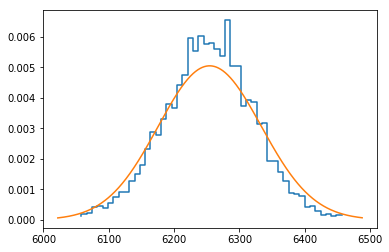

In [7]:
my_hist(flattened, 50)
mean = np.mean(flattened)
std = np.std(flattened)

x = np.linspace(mean - 3 * std, mean + 3 * std, 1000)   # Generate a 3 sigma plot of 1000 points
y = poisson(x, mean)
plt.plot(x, y)

## A short aside regarding CCD gain

It was previously emphasized that Poisson statistics assumes that the events being modelled are independent. While the arrival of an individual photon may very well satisfy this requirement, the generation of an ADU (analog-to-digital unit) by the CCD will certainly not. A better match between the theoretical distribution and the data histogram can be achieved if the histogram is multiplied by the ratio of photoelectrons to ADUs, also known as the **CCD gain**.

Later in the course, we will perform statistical analysis of data to estimate the exact value of gain ($g$). For now, let us assume a typical CCD gain of (roughly) $g=1.8$ photoelectrons per ADU and rescale the data by it:

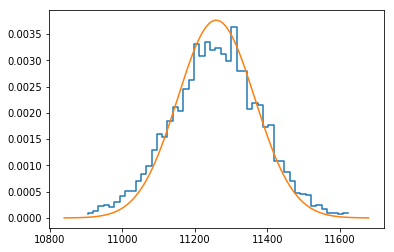

In [8]:
gain_corrected = flattened * 1.8

my_hist(gain_corrected, 50)
mean = np.mean(gain_corrected)
std = np.std(gain_corrected)
x = np.linspace(mean - 3 * std, mean + 3 * std, 1000)
y = poisson(x, mean)
plt.plot(x, y)

## Gaussian (normal) distribution

Defined as:

$$P(x,\mu,\sigma) = \frac{e^{-\frac{(x - \mu)^2}{2\sigma^2}}}{\sqrt{2  \pi  \sigma^2}}$$

is used for modelling the distribution of the mean of multiple observations. It turns out that for a sufficiently large number of measurements, the distribution of their mean is Gaussian regardless of the distribution of the measurements themselves (the so-called *Central Limit Theorem*). Consider the following example:

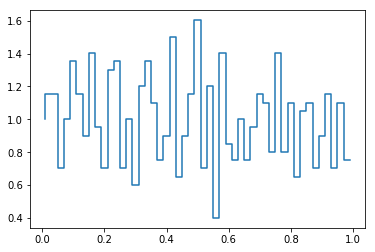

In [9]:
sample_data = np.random.uniform(0, 1, 1000) # Generate 1000 random values between 0 and 1
my_hist(sample_data, 50)

In the cell above, I used *NumPy* to generate $1000$ random numbers between $1$ and $0$ such that the probability of every outcome is the same. The distribution of this dataset has nothing to do with the Gaussian formula, as can be seen in the histogram above. Now, instead of plotting the observations themselves, let's try plotting their mean values:

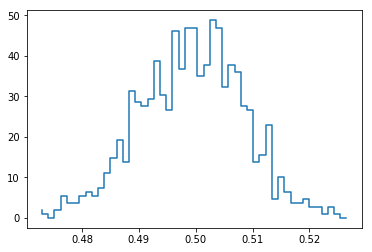

In [10]:
sample_data = np.random.uniform(0, 1, 1000000)        # Generate a million random values
sample_data = np.reshape(sample_data, [1000, 1000])   # Turn those into a 1000x1000 2D array
sample_data = np.mean(sample_data, axis = 1)          # "axis = 1" means "only average along one of the dimensions"
my_hist(sample_data, 50)

Hopefully, the second histogram looks more Gaussian, even though nothing about the original data was. In the case of CCD imaging, the data is expected to follow Poisson distribution, gradually tending towards Gaussian as the number of photons detected increases.

Apart from being less precise for small sample sizes, the Gaussian probability distribution has another major advantage: one needs to know both $\mu$ and $\sigma$ to compute it, whereby the latter may not always be reliably known. This is another reason why Poisson statistics is sometimes preferred, where only $\mu$ needs to be known.

The Gaussian formula is much less computationally demanding than Poisson's, as it does not feature factorials or exponentials with very large indices. Hence, it can be calculated directly without the need for approximations. I leave it up to the students to write the necessary Python function and overplot the Gaussian curve with the data histogram.

## Monte-Carlo approach

Monte-Carlo is a district of Monaco, famous for its casinos, gambling mathematicians and, of course, methods for manipulating probability distributions to make sure that the "house always wins" rule holds. As useful as Poisson and Gaussian distributions may be, they are merely approximations that only work under certain conditions and only to a limited degree of precision.

The *Monte-Carlo approach* employs the ever-increasing power of modern computers to simulate probability distributions, tailor-made for every individual case with arbitrarily high precision. One of the driving motivations behind early Monte-Carlo pioneers was their struggle to statistically predict outcomes of solitaire games, where the rules are complicated enough to make all standard probability distributions useless.

<table><tr><td>
<i>In freecell, there are 32000 different instances of the game. According to the help, "It is believed (although not proven) that every game is winnable." In fact, it has been proven that one game, #11982, is not winnable.
<br><br>
Tim O'Reilly et al pointing out a mistake in the Windows 98 solitaire game help-file. Taken from "Windows 98 in a Nutshell".</i>
></td></tr></table>

The power of Monte-Carlo is best illustrated with a classic example:

<table><tr><td>
What is a probability that a randomly chosen point on a unit (1x1) square lies within a circle, inscribed in that square?
</td></tr></table>

Of course, the answer is the ratio of the area of the circle to the area of the square, i.e. $\pi/4$. The cell below attempts to answer the same question using the Monte-Carlo approach:

In [12]:
# Generate 100000 random pairs of numbers between -0.5 and 0.5 that represent the coordinates on the square
x = np.random.uniform(-0.5, 0.5, 100000)
y = np.random.uniform(-0.5, 0.5, 100000)

# How many are within the circle?
circle_count = len(x[(x ** 2.0 + y ** 2.0) <= (0.5 ** 2.0)])

# What is the probability of that happening?
circle_prob = circle_count / float(len(x))

# What is the value of pi?
print 4.0 * circle_prob

3.13352


Now, let us consider an example more relevant to PHYS164: uncertainty propagation. Consider the following function:

$$y = \ln(x)$$

Suppose that $x$ represents an observable quantity that has been measured to have the mean of $50$ and the standard deviation of $0.2$. Also suppose that the number of experimental trials is sufficiently large to make the distribution of $x$ Gaussian. What is the uncertainty (standard deviation) in $y$?

One way of answering this question is by using the uncertainty propagation equation presented in the lectures:

$$\sigma_y = \sigma_x \times \frac{1}{x} = 0.2/50 = 0.004$$

Below, I do the same calculation using the Monte-Carlo approach:

In [13]:
x = np.random.normal(50, 0.2, 10000)    # This time, we are generating 10000 Gaussian random numbers with
                                        # the mean of 50 and standard deviation of 0.2
    
y = np.log(x)
print "The uncertainty in y is:", np.std(y)

The uncertainty in y is: 0.003976114028287838


With some luck, the value obtained through Monte-Carlo simulations is very close to the theoretically predicted value. There are at least two reasons why you may prefer to propagate uncertainties using Monte-Carlo instead of the propagation formula:

* It is simpler! No algebraic manipulations are required! This is particularly relevant, when the dependence of $y$ on $x$ is very complicated, unknown or non-algebraic!
* If the number of random values is large enough, Monte-Carlo can and will be more accurate than the propagation formula, because it is free of all the simplifying assumptions that were used when deriving the formula, such as $\sigma_x \ll x$.